In [16]:
import imgaug as ia
from imgaug import augmenters as iaa
import os
from glob import glob
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import random

# image augmentation:

After deleting the irrelevant pictures and arranging the rest of the pictures so that each folder now contains the correct pictures of the Roman numeral 

* We will use image augmentation to increase our dataset to contain 10000 samples, 8000  in the training dataset  and 2000 data validation dataset (1,000 images for each of the 10 Roman numeral labels).
* We have transferred all the data to the training folder, 1899 sapmles, the amount of pictures of the  Roman numeral in each file :

In [9]:
train_dir = os.path.join("cleaned", "train")
val_dir = os.path.join("cleaned", "val")

In [10]:
# all the labeles 
numerals =os.listdir(train_dir)


In [11]:
train_data = [os.path.join(dirpath, filename) for dirpath, _, filenames in os.walk(train_dir) for filename in filenames]
len(train_data)


1899

In [12]:
for i in numerals:
    print(f'The amount of data in the folder {i} : ' + str(len(os.listdir(f'{train_dir}/{i}'))) )

The amount of data in the folder i : 243
The amount of data in the folder iii : 156
The amount of data in the folder vi : 169
The amount of data in the folder v : 177
The amount of data in the folder vii : 174
The amount of data in the folder iv : 262
The amount of data in the folder ii : 158
The amount of data in the folder viii : 172
The amount of data in the folder x : 175
The amount of data in the folder ix : 213


We used imgaug imgaug library, it's a library for image augmentation in machine learning experiments. 
It supports a wide range of augmentation techniques, allows to easily combine these and to execute them in random order or on multiple CPU cores, has a simple yet powerful stochastic interface and can not only augment images, but also keypoints/landmarks, bounding boxes, heatmaps and segmentation maps

We applied a set of generic augmentation steps for all images with the help of the imgaug library:

1. AdditiveGaussianNoise : Add noise sampled from gaussian distributions elementwise to images.
2. Resize :- Augmenter that resizes images to specified heights and widths.(The maximum horizontal and vertical length is selected between all images)
3. GaussianBlur : Augmenter to blur images using gaussian kernels.
4. AdditiveLaplaceNois : Add noise sampled from laplace distributions elementwise to images.
5. Multiply : Multiply all pixels in an image with a specific value, thereby making the image darker or brighter
6. JpegCompression : Degrade the quality of images by JPEG-compressing them.



### There are certain labels where flippin makes sense, and others where flippin does not
##### Divide numbers into four groups and explain which groups need horizontal or vertical inversion or both or without none : 

#### 1. Groub of =  iv , vi , vii , viii :
- flipping them horizontally or vertically will result in numbers that do not resemble the original digits, And so we will not  flip them into any side.

#### 2. Groub of  =  v : 
- doing a horizontal flip will still allow us to get another variation of the same digit, And so we will  flip them into random horizontal flipping .

#### 3. Groub of  =  ix : 
- doing a vertical flip will still allow us to get another variation of the same digit, And so we will  flip them into random vertical flipping .

#### 4. Groub of  =   i, ii, iii, x : 
- both horizontal and vertical flipping yield new variations of the image that still resemble the original digits, And so we will  flip them into both random vertical flipping and horizontal flipping.

In [6]:
#iv, vi, vii, viii
aug_Noflip = iaa.Sequential([
    iaa.AdditiveGaussianNoise(scale=0.1*255),
    iaa.Resize({"height": 390, "width":275}),
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=2.0)),
    iaa.AdditiveLaplaceNoise(scale=(0, 0.2*255)),
    iaa.Multiply((0.5, 1.5)),
    iaa.JpegCompression(compression=(70, 99)),    
], random_order=False)

# v
aug_Hflip = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.AdditiveGaussianNoise(scale=0.1*255),
    iaa.Resize({"height": 390, "width":275}),
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=2.0)),
    iaa.AdditiveLaplaceNoise(scale=(0, 0.2*255)),
    iaa.Multiply((0.5, 1.5)),
    iaa.JpegCompression(compression=(70, 99)),    
], random_order=False)

#  ix
aug_Vflip = iaa.Sequential([
    iaa.Flipud(0.5), 
    iaa.AdditiveGaussianNoise(scale=0.1*255),
    iaa.Resize({"height": 390, "width":275}),
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=2.0)),
    iaa.AdditiveLaplaceNoise(scale=(0, 0.2*255)),
    iaa.Multiply((0.5, 1.5)),
    iaa.JpegCompression(compression=(70, 99)),    
], random_order=False)

# i, ii, iii, x
aug_HVflip = iaa.Sequential([
    iaa.Flipud(0.5), 
    iaa.Fliplr(0.5),
    iaa.AdditiveGaussianNoise(scale=0.1*255),
    iaa.Resize({"height": 390, "width":275}),
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=2.0)),
    iaa.AdditiveLaplaceNoise(scale=(0, 0.2*255)),
    iaa.Multiply((0.5, 1.5)),
    iaa.JpegCompression(compression=(70, 99)),    
], random_order=False)

In [7]:
# dictionary and function that help as wditting the right augmentation
augment_dect={
            1: aug_Noflip ,
            2 : aug_Hflip,
            3 : aug_Vflip,
            4 : aug_HVflip}

def num_aug(num):
    if num =='v' :
        return augment_dect[2]
    elif num == 'ix' :
        return augment_dect[3]
    elif num == 'i' or num == 'ii' or num== 'iii' or num ==  'x':
        return augment_dect[4]
    else : return augment_dect[1]

In [22]:
# creat a folder to copy all the data to it and work in it in this folder  :

directory = "all_data"

all_path = os.path.join(directory) 

os.mkdir(all_path)

# Visualization of Augmentation

In [75]:
# function that help us to visualizes the augmentation : 

def show_single_transform(num):
    images, filenames = [], []
    for image in os.listdir(f'{train_dir}/{num}'):
        images.append(os.path.join(train_dir,num, image))
        filenames.append(f'{image}')
        
    random_index = random.choice(range(len(images)))
    random_filename = filenames[random_index]
    random_img = images[random_index]
    
    img_original = Image.open(random_img)
    img_original = ImageOps.grayscale(img_original)
    
    aug_seq = num_aug(num)

    try:
        img_transformed = aug_seq(img_original)
    except:
        img_transformed = aug_seq(images=np.asarray(img_original))
    print(f'Successful image Augmentation')
    
    # Display images side by side
    fig = plt.figure(figsize=(14, 8))
    
    # show original image
    fig.add_subplot(221)
    plt.title('Original Image')
    plt.axis('off')
    plt.imshow(img_original, cmap=plt.get_cmap('gray'))
    fig.add_subplot(222)
    plt.title('Transformed Image')
    plt.axis('off')
    plt.imshow(img_transformed, cmap=plt.get_cmap('gray'))
    
    plt.show();


Successful image Augmentation


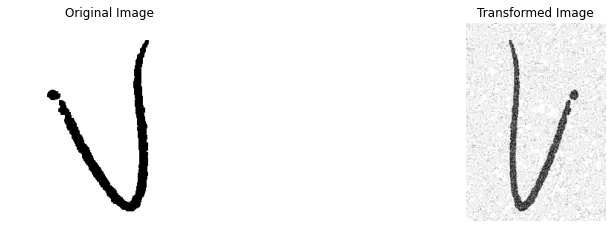

In [62]:
# Augmentation of the Groub of = v :

show_single_transform('v')

Successful image Augmentation


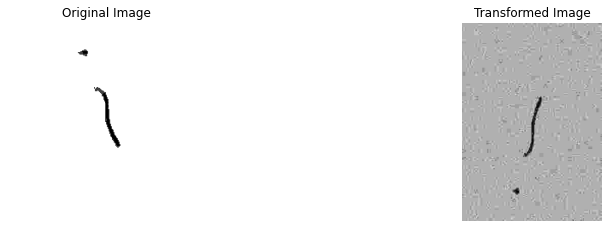

In [70]:
# Augmentation of the Groub of = i : 

show_single_transform('i')

Successful image Augmentation


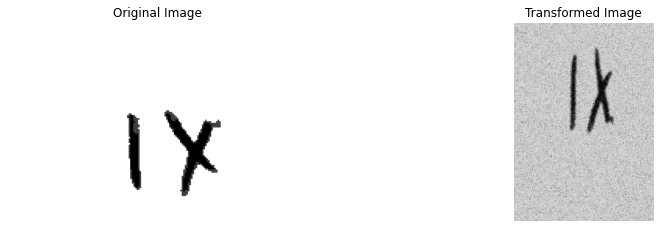

In [71]:
# Augmentation of the Groub of = ix : 

show_single_transform('ix')

Successful image Augmentation


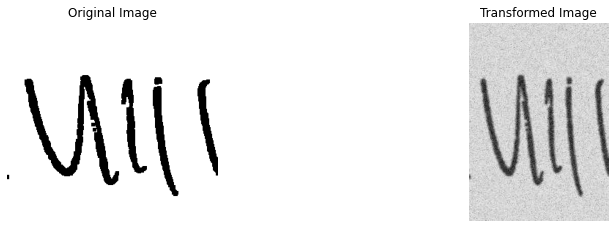

In [73]:
# Augmentation of the Groub of = viii :

show_single_transform('viii')

# The augmentation over all the data : 

In [ ]:
# Go through all the numerals and do the augmentation : 

for num in numerals:
    # creat folder to save the org imgs:
    all_data_num =  f'{all_path}/{num}'
    
    # final path of the num data:
    org_path =  f'{train_dir}/{num}'
    print(all_data_num)

    # copy all the data to new folder :
    shutil.copytree(org_path, all_data_num)
    
    # ceate new folders for the num to but the The final result of the 1000 images of every num :
    data_train = f'{all_path}/train/{num}'
    data_val = f'{all_path}/val/{num}'
    Path(data_train).mkdir(parents=True, exist_ok=True)
    Path(data_val).mkdir(parents=True, exist_ok=True)
    
    img_files = glob(os.path.join(all_data_num, "*.png"))
    g = len(img_files)
    
    # Find the complementary number to 1000 :
    count = 1000 - g
    print(len(img_files))
    
    aug_seq = num_aug(num)
    n = 0
    # Go through (the complementary number to 1000) times and create new images 
    # according to the corresponding augmentation for the num :
    for i in range(count):
        n += 1
        
        random_index = random.choice(range(len(img_files)-1))
        random_file = img_files[random_index]
        img_random = Image.open(random_file)
        img_random = ImageOps.grayscale(img_random)

        # This is where the augmentation is done : 
        try:
            transformed_img_random = aug_seq(img_random)
        except:
            transformed_img_random = aug_seq(images=np.asarray(img_random))   



        # Convert back to PIL to save
        transformed_img_random = Image.fromarray(transformed_img_random)     
        transformed_img_random.save(f'{all_data_num}/{num}_random_{i}.png', 'PNG')
    
    # Distribute the 1000 samples for training and validation datasets : 
    
    imgs = glob(os.path.join(all_data_num, "*.png"))
    train_imgs = random.sample(imgs,800)
    val_imgs = [x for x in imgs if x not in train_imgs]
    for file in train_imgs:
        shutil.copy(file, data_train)
    for file in val_imgs:
        shutil.copy(file, data_val)
    # 
    shutil.rmtree(all_data_num, ignore_errors=True)